In [1]:
import numpy as np
import xarray as xr
from sklearn.decomposition import PCA
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
# open up the dataset we just spent a long time processing:
ds = xr.open_dataset("eddy_data.nc")
display(ds)

<xarray.Dataset>
Dimensions:   (latitude: 721, pressure: 37, time: 516)
Coordinates:
  * latitude  (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time      (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
  * pressure  (pressure) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
Data variables:
    u         (time, pressure, latitude) float32 ...
    v         (time, pressure, latitude) float32 ...
    EKE       (time, pressure, latitude) float32 ...
    KE_zonal  (time, pressure, latitude) float32 ...
    wpTp      (time, pressure, latitude) float32 ...
    upvp      (time, pressure, latitude) float32 ...
    EP_merid  (pressure, latitude, time) float64 ...
    EP_vert   (latitude, pressure, time) float64 ...
    cape      (time, latitude) float32 ...
    vpTp      (time, pressure, latitude) float32 ...
    vpheatp   (time, pressure, latitude) float32 ...

we have already processed the data, but to do the PCA (and replicate the results of the paper) we need to area and mass weight the data. Following the paper, we will also only look at the troposphere (ish) i.e. < 200 hPa and the southern hemisphere (20-70) S. 

In [3]:
ds = ds.transpose("time", "pressure", "latitude")

In [4]:
ds["level_wgt"] = ds["pressure"]*100/9.8 # assume hydrostatic balance

latitude = ds["latitude"]
ds["area_wgt"] = np.cos(np.deg2rad(latitude))

SH = np.logical_and(ds['latitude'] <= -20, ds['latitude'] >= -70)
p_low = ds["pressure"] > 200

# get axes for later plotting
pressure = np.array(ds["pressure"])[p_low]
lats_SH = np.array(ds['latitude'])[SH]

smaller_wgts = np.array((ds["level_wgt"][p_low])*(ds["area_wgt"][SH]))

now we can weight the data and calculate the PCA to diagnose the SAM (1st EOF of zonal mean zonal wind) and the BAM (1st EOF of EKE). We are only going to calculate 1 component as that is all we really need (and makes easier use of the sklearn functions). Note that the transformed version of the data can serve as the SAM/BAM index.

In [5]:
ncomps = 1
u_wgt = ds["u"]*ds["level_wgt"]*ds["area_wgt"]
EKE_wgt = ds["EKE"]*ds["level_wgt"]*ds["area_wgt"]

In [6]:
# compute the PCA for zonal mean zonal wind
u_SH = np.array(u_wgt[:,p_low,SH]) # has shape (516, 22, 201)
u_SH = np.reshape(u_SH, [len(ds["time"]),-1])

pca = PCA(n_components=ncomps)
SAM_ind = pca.fit_transform(u_SH)

# print the singular values and explained variance ratio (first 10)
print("explained var ratio: ", pca.explained_variance_ratio_[0:10])
print("\n singular values: ",pca.singular_values_[0:10]) 

u_SH_comps = np.array([np.reshape(comp, [len(pressure),len(lats_SH)]) 
              for comp in pca.components_])

explained var ratio:  [0.68290866]

 singular values:  [13789946.91715781]


In [7]:
# compute the PCA for EKE
EKE_SH = np.array(EKE_wgt[:,p_low,SH]) # has shape (516, 37, 360)
EKE_SH = np.reshape(EKE_SH, [len(ds["time"]),-1])

pca_eke = PCA(n_components=ncomps)
BAM_ind = pca_eke.fit_transform(EKE_SH)

# print the singular values and explained variance ratio (first 10)
print("explained var ratio: ", pca_eke.explained_variance_ratio_[0:10])
print("\n singular values: ",pca_eke.singular_values_[0:10]) 

EKE_SH_comps = np.array([np.reshape(comp, [len(pressure),len(lats_SH)]) 
              for comp in pca_eke.components_])

explained var ratio:  [0.55922841]

 singular values:  [24402734.0744566]


Now I will plot the components, after reweighting them for consistency with the original units.

In [8]:
EKE_SH_comps =  np.array([comp*smaller_wgts for comp in EKE_SH_comps])
u_SH_comps =  np.array([comp*smaller_wgts for comp in u_SH_comps])

before plotting, I will just transform the SAM/BAM indices such that they are related to spatial patterns for later regression

In [9]:
BAM_proj = np.reshape(pca_eke.inverse_transform(BAM_ind), (len(ds["time"]), len(pressure), -1))
SAM_proj = np.reshape(pca.inverse_transform(SAM_ind), (len(ds["time"]), len(pressure), -1))

## Plots of 1st EOF of zonal mean zonal wind 

<Figure size 432x288 with 0 Axes>

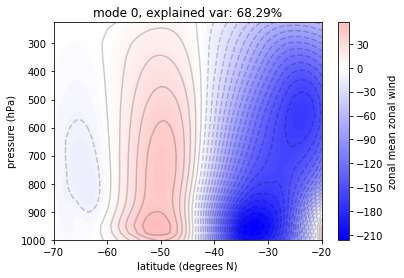

In [10]:
maxamp = np.max(np.abs(u_SH_comps))
# plot the first 10 components
for j in range(ncomps):
    plt.clf()
    plt.figure()
    plt.contourf(lats_SH, pressure, u_SH_comps[j], levels = 100, cmap = 'bwr', vmin = -1*maxamp, vmax = maxamp)
    plt.colorbar(label = "zonal mean zonal wind")
    plt.contour(lats_SH, pressure, u_SH_comps[j], levels = 30, vmin = -1*maxamp, vmax = maxamp, alpha = 0.2, colors = "black")
    plt.gca().invert_yaxis()
    plt.title("mode " + str(j) + ", explained var: " + str(round(pca.explained_variance_ratio_[j]*100, 2)) + "%")
    plt.xlabel("latitude (degrees N)")
    plt.ylabel("pressure (hPa)")
    # plt.gca().set_yscale('log')
    plt.show()

## Plots of 1st EOF of EKE

<Figure size 432x288 with 0 Axes>

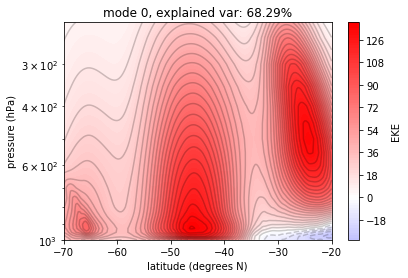

In [11]:
# plot the first 10 components
maxamp = np.max(np.abs(EKE_SH_comps))
for j in range(ncomps):
    plt.clf()
    plt.figure()
    plt.contourf(lats_SH, pressure, EKE_SH_comps[j], levels = 100, cmap = 'bwr', vmin = -1*maxamp, vmax = maxamp)
    plt.colorbar(label = "EKE")
    plt.contour(lats_SH, pressure, EKE_SH_comps[j], levels = 30, alpha = 0.2, colors = "black")
    plt.gca().invert_yaxis()
    plt.title("mode " + str(j) + ", explained var: " + str(round(pca.explained_variance_ratio_[j]*100, 2)) + "%")
    plt.xlabel("latitude (degrees N)")
    plt.ylabel("pressure (hPa)")
    plt.gca().set_yscale('log')
    plt.show()

Luckily these plots don't look too different from the ones in Thomspon and Woodworth 2014, which is a good sign. I find it interesting that decreasing the temporal resolution of the data (daily to monthly) hasn't made a huge effect qualitatively. The modes aren't exactly the same  - *but*  the shapes are, which doesn't exactly match with the characterization of the BAM having a characteristic 25 day mode.

Now we can use these indices to regress onto the data:

In [12]:
def regressiontoind(varr, modeind):
    # somewhat inefficiently regress a variable (varr) onto the index of a mode
    oldshape = varr.shape
    varr = np.reshape(varr, [oldshape[0], -1])
    rtot = varr.shape[-1]
    if len(oldshape) < 3:
        holding = np.zeros((oldshape[1], 5))
    else:
        holding = np.zeros((oldshape[1]*oldshape[2], 5))
    
    for j in range(rtot):
        slope, intercept, r, p, se = stats.linregress(modeind, varr[:,j])
        
        holding[j,0] = slope
        holding[j,1] = intercept
        holding[j,2] = r
        holding[j,3] = p
        holding[j,4] = se
    if len(oldshape) < 3:
        holding = np.reshape(holding, (oldshape[1], 5))
    else:
        holding = np.reshape(holding, (oldshape[1], oldshape[2], 5))
    return holding

In [13]:
def plotregression(pltslopes, varname, indname):
    maxamp = np.max(np.abs(pltslopes))
    plt.figure()
    plt.contourf(lats_SH, pressure, pltslopes, levels = 100, cmap = 'bwr', vmin = -1*maxamp, vmax = maxamp)
    plt.colorbar(label = varname)
    plt.contour(lats_SH, pressure,pltslopes, levels = 30, alpha = 0.2, colors = "black")
    plt.gca().invert_yaxis()
    plt.title("regression: " + indname + " v. " + varname)
    plt.xlabel("latitude (degrees N)")
    plt.ylabel("pressure (hPa)")
    # plt.gca().set_yscale('log')
    plt.show()

In [14]:
var_names = list(ds.keys())[:11]

In [15]:
SAM_regressions = [regressiontoind(np.array(ds[named]), SAM_ind.flatten()) 
                   for named in var_names]
SAM_regressions = np.array(SAM_regressions)

In [16]:
cape_regression_SAM = SAM_regressions[8]
SAM_regressions = np.array([SAM_regressions[j] for j in range(11) if j != 8])

In [17]:
BAM_regressions = [regressiontoind(np.array(ds[named]), BAM_ind.flatten()) 
                   for named in var_names]
BAM_regressions = np.array(BAM_regressions)
cape_regression_BAM = BAM_regressions[8]
BAM_regressions = np.array([BAM_regressions[j] for j in range(11) if j != 8])

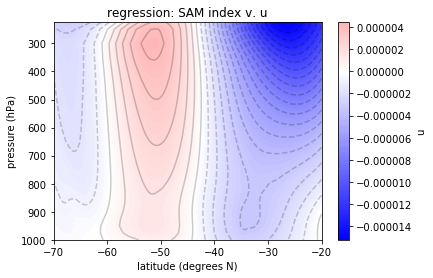

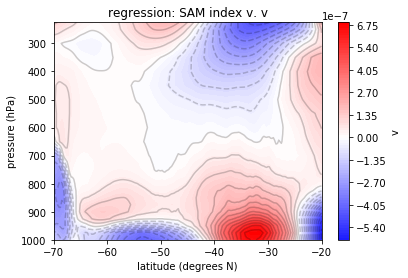

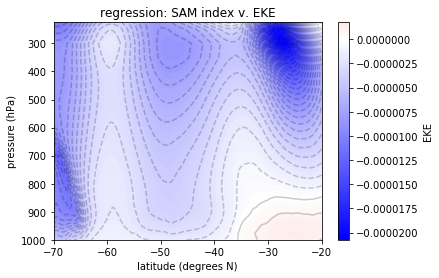

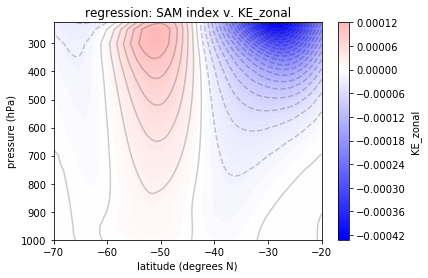

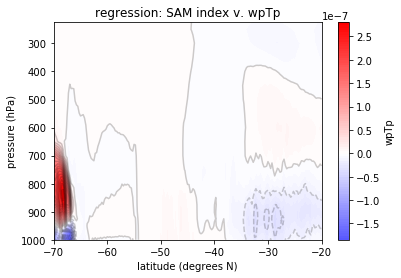

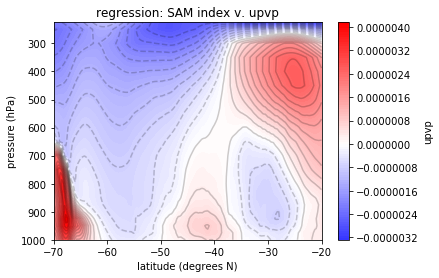

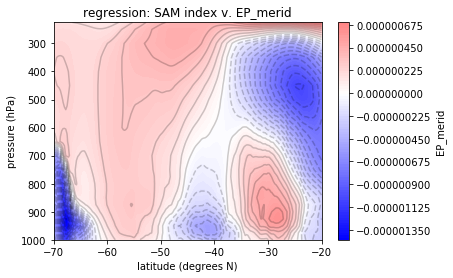

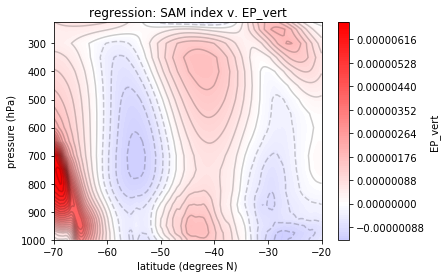

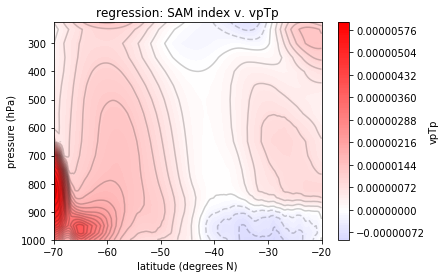

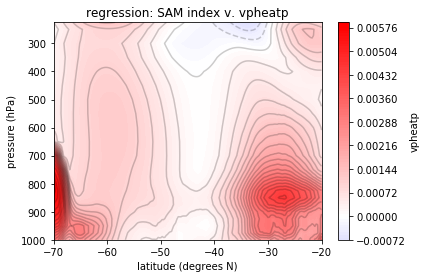

In [18]:
for j in range(10):
    pltslopes = SAM_regressions[j]
    pltslopes = (pltslopes[p_low])[:,SH, 0]
    indname = "SAM index"
    if j >= 8:
        vname = var_names[j + 1]
    else:
        vname = var_names[j]
    plotregression(pltslopes, vname, indname)

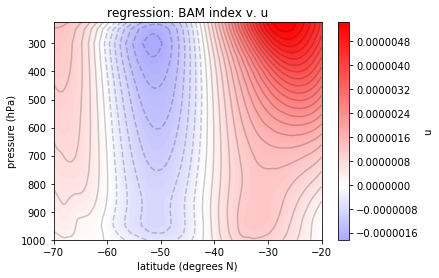

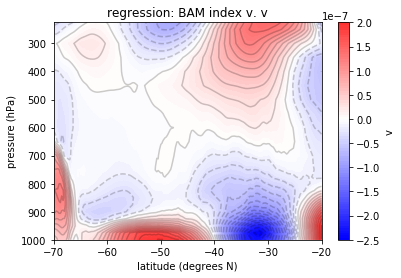

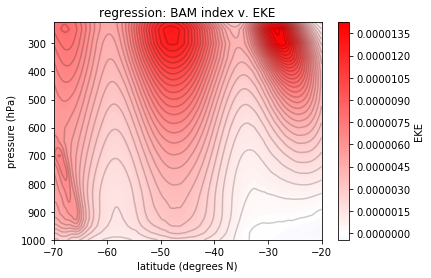

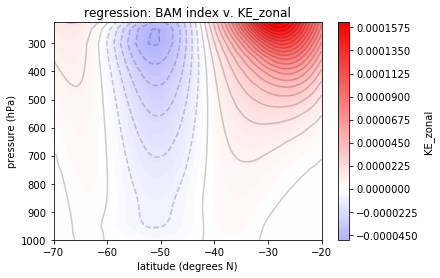

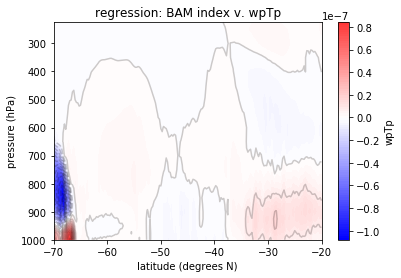

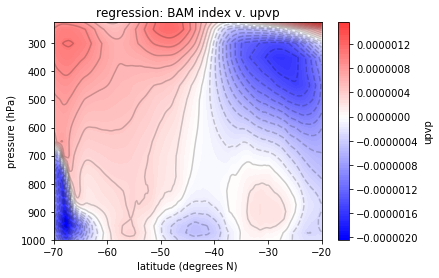

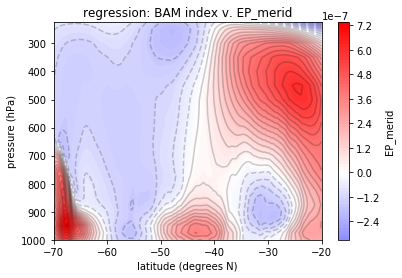

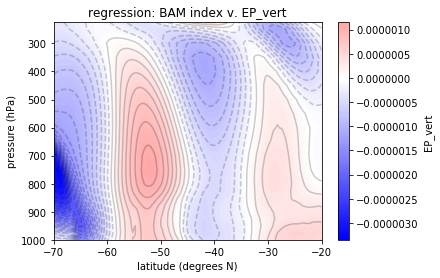

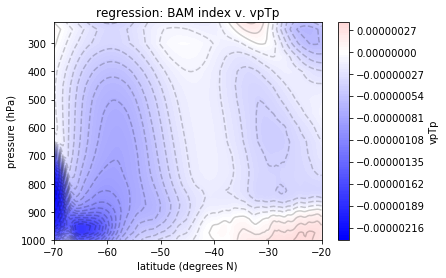

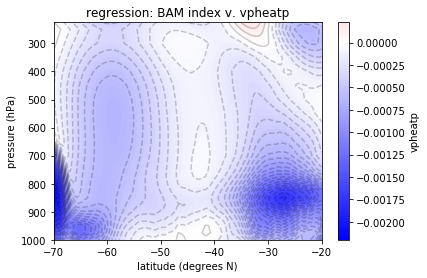

In [19]:
for j in range(10):
    pltslopes = BAM_regressions[j]
    pltslopes = (pltslopes[p_low])[:,SH, 0]
    indname = "BAM index"
    if j >= 8:
        vname = var_names[j + 1]
    else:
        vname = var_names[j]
    plotregression(pltslopes, vname, indname)

also do the same in plotting the regressions for CAPE — except I will plot the $r^2$ value as the units of the slopes are quite small — so the visualizaiton isn't excellent. What is happening between 50-60 degrees S? This seems to be some sort of artifact of my computations but is intriguing nonetheless.

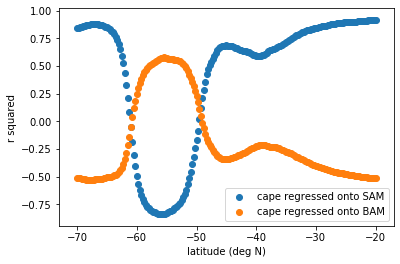

In [20]:
plt.clf()
plt.scatter(lats_SH, cape_regression_SAM[SH, 2], label = "cape regressed onto SAM")
plt.scatter(lats_SH, cape_regression_BAM[SH, 2], label = "cape regressed onto BAM")
plt.ylabel("r squared")
plt.xlabel("latitude (deg N)")
plt.legend()
plt.show()

Ultimately, despite the qualitatively similarity between the first PCA components of the SAM and BAM, moving the monthly data does quantitatively change the regressions of other variables onto the BAM/SAM. It seems that the BAM and SAM indices are anticorrelated if computed this way. Perhaps a cause of this could be that the BAM no longer has it's signature ~25 day period? Unfortunately, I am not familiar enough with the literature on these modes to know how consistent these results are with more thorough analysis. In another notebook, I will do an abbreviated analysis of the BAM and SAM with daily data. 